# 支持向量机应用

## 构建模型

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek
# 均匀分类
from collections import Counter
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

## 读取数据

In [2]:
src_dir = r'dataset'
data_dir = os.path.join(src_dir, '原始数据')

In [3]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import auc, roc_curve

In [4]:
def trans_dataset(data_dir, src_data='train_data_final.csv'):
    """
    划分数据
    训练集&验证集: train_test_split
    测试集: test_data_final
    :param data_dir: 
    :param src_data: 
    :return: x_train, x_test, y_train, y_test, x_train_st, y_train_st, x_train_st_tiny, x_test_st_tiny
    """
    dataset = pd.read_csv(os.path.join(data_dir, src_data), index_col=0)
    X = dataset.drop(['Y'], axis=1).values
    Y = np.array(dataset['Y'])
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

    # 非平衡数据处理，旨在获得边界清晰且平衡的数据集
    # SMOTE (增加少数类样本) +TOMEK (删除不符合要求的多数类样本)
    data_pairs = [(x_train, x_test, y_train, y_test)]
    st = SMOTETomek(random_state=0)
    x_train_st, y_train_st = st.fit_resample(x_train, y_train)

    # 基于重要性权重选择特征的元变换器
    sfm = SelectFromModel(LogisticRegression(penalty="l1", solver='liblinear', C=1.0))
    sfm.fit(x_train, y_train)
    x_train_tiny = sfm.transform(x_train)
    x_test_tiny = sfm.transform(x_test)
    sfm.fit(x_train_st, y_train_st)
    x_train_st_tiny = sfm.transform(x_train_st)
    x_test_st_tiny = sfm.transform(x_test)  # shape: (8999，44)
    return x_train, x_test, y_train, y_test, x_train_st, y_train_st, x_train_st_tiny, x_test_st_tiny

In [5]:
def save_txt(x_test_st_tiny, y_test, y_pred, y_proba, src_dir, txt_name='GaussianNB.txt'):
    """
    保存txt文件
    :param x_test_st_tiny: 
    :param y_test: 
    :param y_pred: 
    :param y_proba: 
    :param src_dir: 
    :param txt_name: 
    :return: save file
    """
    col = np.arange(x_test_st_tiny.shape[0])
    np.savetxt(fname=os.path.join(src_dir, txt_name),
               X=(col, y_test, y_pred, y_proba))
    data = np.genfromtxt(fname=os.path.join(src_dir, txt_name))
    # 转置
    transpose_data = np.transpose(data)
    np.savetxt(fname=os.path.join(src_dir, txt_name), X=transpose_data,
               fmt="%d %d %d %0.10f ", delimiter='\n', newline="\n")

In [6]:
def draw_auc(y_true, y_proba, title="GaussianNB with L1 Penalty", png_name="GaussianNB_auc.png", lw=2):
    """
    AUC曲线
    :param y_true: 
    :param y_proba: 
    :param title: 
    :param png_name: 
    :param w: 
    :param lw: 
    :return: 
    """
    fpr, tpr, _ = roc_curve(y_true, y_proba, pos_label=1)
    auc_value = auc(fpr, tpr)
    plt.figure(figsize=(4, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label=f'ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{title}(area={auc_value:.2%})')
    plt.legend(loc="lower right")
    plt.savefig(os.path.join(src_dir, png_name), dpi=800)
    plt.show()

In [7]:
def draw_cm(y_true, y_pred, title="GaussianNB with L1 Penalty", png_name="GaussianNB_cm.png", labels=[0, 1]):
    """
    混淆矩阵
    :param y_true: 
    :param y_pred: 
    :param title: 
    :param png_name: 
    :param labels: 
    :return: 
    """
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    score = accuracy_score(y_true, y_pred)
    plt.figure(figsize=(5, 5))
    plt.matshow(cm, fignum=0, cmap=plt.cm.Reds)
    plt.colorbar()
    for x in range(len(cm)):
        for y in range(len(cm)):
            plt.annotate(cm[x, y], xy=(x, y), fontsize=10.5,
                         horizontalalignment='center',
                         verticalalignment='center')
    plt.xlabel('True Class', fontsize=10.5)
    plt.ylabel('Pred class', fontsize=10.5)
    plt.title(f"{title}(score={score:.2%})", fontsize=12)
    plt.savefig(os.path.join(src_dir, png_name))
    plt.show()

In [8]:
x_train, x_test, y_train, y_test, x_train_st, y_train_st, x_train_st_tiny, x_test_st_tiny = trans_dataset(data_dir,
                                                                                                          src_data='train_data_final.csv')

In [9]:
x_train, x_test, y_train, y_test, x_train_st, y_train_st, x_train_st_tiny, x_test_st_tiny

(array([[-1.07986753e+00, -1.09079819e-16,  1.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 3.53993841e-02, -1.09079819e-16,  1.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.15066630e+00, -1.09079819e-16,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [-1.50881852e-16, -4.37003663e-01,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 3.53993841e-02, -1.09079819e-16,  0.00000000e+00, ...,
          0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
        [ 3.53993841e-02, -1.09079819e-16,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]),
 array([[ 3.53993841e-02,  2.69845972e-01,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.15066630e+00, -1.09079819e-16,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e

## 构建模型

### SVM
支持向量机（Support Vector Machine，SVM）属于有监督学习模型，主要用于解决数据分类问题。通常SVM用于二元分类问题，对于多元分类可将其分解为多个二元分类问题，再进行分类，主要应用场景有图像分类、文本分类、面部识别和垃圾邮件检测等领域。

In [10]:
from sklearn.svm import SVC

In [11]:
model_3 = SVC(kernel='linear', C=0.1, probability=True)
model_3.fit(x_train_st_tiny, y_train_st)
y_pred = model_3.predict(x_test_st_tiny)
y_proba = model_3.predict_proba(x_test_st_tiny)[:, 1]

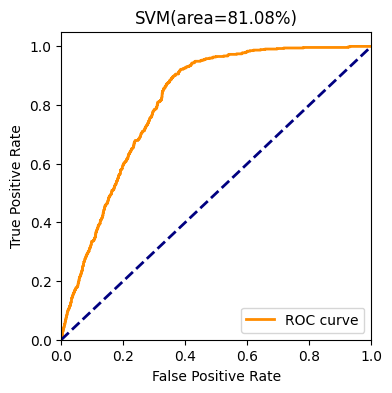

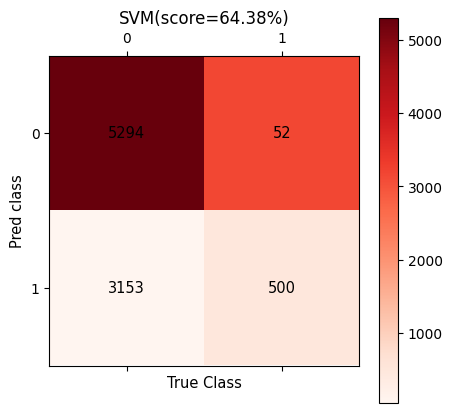

In [12]:
save_txt(x_test_st_tiny, y_test, y_pred, y_proba, src_dir, txt_name='SVM.txt')
draw_auc(y_test, y_proba, title='SVM', png_name="SVM_auc.png")
draw_cm(y_test, y_pred, title="SVM", png_name="SVM_cm.png")

### 随机森林
随机森林近年来广泛应用的领域是信用评估，信用评估中样本量较大，原始数据存在较多的空值，并且数据中离散变量占多数。随机森林模型可以很好地处理这样的数据，因此可以选用随机森林算法对贷款违约行为的数据进行拟合预测。
随机森林模型虽然对空值不敏感，但在部分样本的特征属性为空值的情况下，仍可以维持分类的准确度。随机森林模型既能够通过随机抽取的方式，抽取不同的特征变量进行分类，又能够处理大批量、多维度的复杂数据，模型的泛化能力强，不易造成过拟合问题，而且具有较高的分类准确度。
随机森林要求每个决策树差异尽可能的大，从而在最大程度上减少模型的方差。随机森林模型超参数，比较复杂，不仅需要每一棵决策树的参数，还需要整个集成模型的参数，经检验发现，随机森林在非平衡数据上依旧有着很好的效果。

In [13]:
from sklearn.ensemble import RandomForestClassifier

In [14]:
model_4 = RandomForestClassifier(n_estimators=100, criterion='gini', n_jobs=-1)
model_4.fit(x_train_st_tiny, y_train_st)
y_pred = model_4.predict(x_test_st_tiny)
y_proba = model_4.predict_proba(x_test_st_tiny)[:, 1]

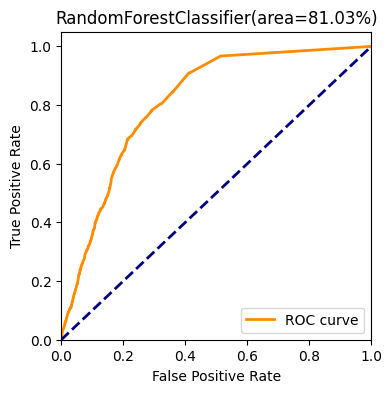

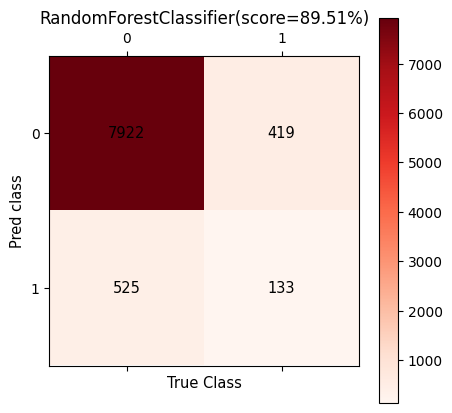

In [15]:
save_txt(x_test_st_tiny, y_test, y_pred, y_proba, src_dir,
         txt_name='RandomForestClassifier.txt')
draw_auc(y_test, y_proba, title="RandomForestClassifier",
         png_name="RandomForestClassifier_auc.png")
draw_cm(y_test, y_pred, title="RandomForestClassifier",
        png_name="RandomForestClassifier_cm.png")